In [98]:
import functools
import pathlib
import pickle
import warnings

import numpy as np
import pandas as pd
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, 
                              GradientBoostingRegressor, RandomForestRegressor)
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

import model_util

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [66]:
data = pathlib.Path.cwd() / 'data'
npys = data / 'npys'
pkls = data / 'pkls'

In [52]:
def merge_features(name):
    """Merge all serialized features into a single dataframe.
    
    Parameters
    ----------
    name : str
        'train' or 'valid'
    
    Returns
    -------
    df : DataFrame
        DataFrame with all the features combined.
    """
    
    essay_df = pd.read_pickle(pkls / f'{name}.pkl')
    descr_df = pd.read_pickle(pkls / 'descr.pkl')[['essay_set', 'grade_level']]
    essay_to_grade_level = descr_df.set_index('essay_set').to_dict()['grade_level']
    
    grade_level_arr = essay_df['essay_set'].map(essay_to_grade_level).values
    grade_level_df = pd.DataFrame(grade_level_arr, columns=['grade_level'])
    
    promt_count_arr = np.load(npys / f'{name}_prompt_count.npy')
    promt_count_df = pd.DataFrame(promt_count_arr, columns=['prompt_count'])
    
    promt_tfidf_arr = np.load(npys / f'{name}_prompt_tfidf.npy')
    promt_tfidf_df = pd.DataFrame(promt_tfidf_arr, columns=['prompt_tfidf'])

    pos_df = pd.read_pickle(pkls / f'{name}_pos.pkl')
    pos_df = pos_df.div(pos_df.sum(axis=1), axis=0)
    
    percent_df = essay_df[['domain1_percent', 'domain2_percent']]
    sentiment_df = pd.read_pickle(pkls / f'{name}_sentiment.pkl')
    diff_level_df = pd.read_pickle(pkls / f'{name}_grade_level.pkl')
    
    dfs = [grade_level_df, percent_df, promt_count_df, promt_tfidf_df,
           diff_level_df, sentiment_df, pos_df]
    return pd.concat(dfs, axis=1)

In [53]:
train_df = merge_features('train')
train_df.head()

,grade_level,domain1_percent,domain2_percent,prompt_count,prompt_tfidf,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,8,60.0,NaN,0.415474,0.297531,74.02,10.4,8.5,8.48,11.3,...,0.063218,0.002874,0.040230,0.011494,0.034483,0.040230,0.000000,0.002874,0.0,0.005747
1,8,70.0,NaN,0.339572,0.235998,67.08,11.6,9.1,7.78,9.9,...,0.067130,0.018519,0.046296,0.009259,0.037037,0.013889,0.004630,0.000000,0.0,0.020833
2,8,50.0,NaN,0.638644,0.529368,68.20,12.0,8.7,8.24,9.8,...,0.044828,0.003448,0.031034,0.000000,0.079310,0.024138,0.000000,0.017241,0.0,0.010345
3,8,80.0,NaN,0.418874,0.286866,53.34,13.9,12.3,11.20,15.4,...,0.052910,0.031746,0.008818,0.015873,0.042328,0.021164,0.003527,0.005291,0.0,0.007055
4,8,60.0,NaN,0.411188,0.297567,72.66,11.3,7.0,7.83,7.5,...,0.088795,0.004228,0.012685,0.004228,0.035941,0.038055,0.006342,0.002114,0.0,0.010571


In [54]:
valid_df = merge_features('valid')
valid_df.head()

,grade_level,domain1_percent,domain2_percent,prompt_count,prompt_tfidf,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,8,50.0,NaN,0.565212,0.410547,56.59,12.7,11.1,10.39,13.3,...,0.041841,0.008368,0.046025,0.008368,0.058577,0.020921,0.000000,0.008368,0.0,0.008368
1,8,60.0,NaN,0.370156,0.274027,80.31,10.2,6.1,5.86,6.4,...,0.081325,0.012048,0.012048,0.009036,0.066265,0.030120,0.000000,0.006024,0.0,0.015060
2,8,70.0,NaN,0.401037,0.297338,64.88,11.9,12.0,7.85,14.6,...,0.057778,0.013333,0.062222,0.006667,0.040000,0.033333,0.006667,0.006667,0.0,0.004444
3,8,70.0,NaN,0.325612,0.227408,73.17,9.9,6.8,7.30,7.1,...,0.090426,0.000000,0.031915,0.007979,0.071809,0.013298,0.000000,0.005319,0.0,0.023936
4,8,70.0,NaN,0.549260,0.404606,74.90,10.2,6.1,7.58,6.6,...,0.052980,0.000000,0.017660,0.000000,0.066225,0.015453,0.013245,0.004415,0.0,0.004415


In [75]:
X_train = train_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_train = train_df['domain1_percent']

X_valid = valid_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_valid = valid_df['domain1_percent']

In [84]:
metrics = [mean_absolute_error, mean_squared_error, r2_score]
grid_cv = functools.partial(model_util.grid_search_cv, X=X_train, y=y_train)
score_est = functools.partial(model_util.score_estimator, 
                              metrics=metrics, 
                              X=X_train,
                              y=y_train)
plot_resid = functools.partial(model_util.plot_residuals, X=X_train, y=y_train)

# Linear Regression

In [85]:
linear_reg = LinearRegression()
score_est(linear_reg)

{'mean_absolute_error': 16.00433590024254,
 'mean_squared_error': 420.88656259023344,
 'r2_score': 0.18016830573938655}

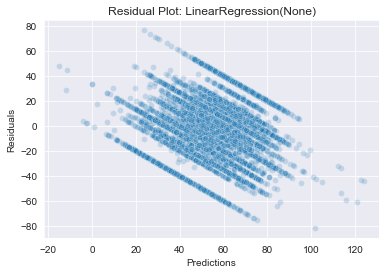

In [86]:
plot_resid(linear_reg)

# Lasso

In [89]:
param_grid = {'alpha': [10**i for i in range(-3, 4)], 'max_iter': [10_000]}
lasso_best = grid_cv(Lasso(), param_grid)
lasso_best

/Users/matteding/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.01, 'max_iter': 10000}

In [90]:
lasso = Lasso(**lasso_best)
score_est(lasso)

{'mean_absolute_error': 16.009587229140926,
 'mean_squared_error': 417.58563560206005,
 'r2_score': 0.1851959427023115}

/Users/matteding/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


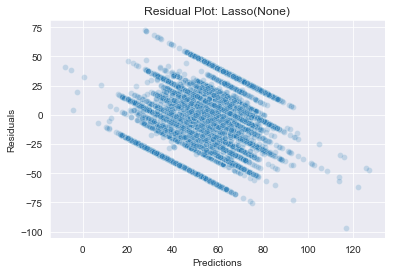

In [91]:
plot_resid(lasso)

# Ridge

In [92]:
param_grid = {'alpha': [10**i for i in range(-3, 4)]}
ridge_best = grid_cv(Ridge(), param_grid)
ridge_best

{'alpha': 10}

In [93]:
ridge = Ridge(**ridge_best)
score_est(ridge)

{'mean_absolute_error': 15.967741920188981,
 'mean_squared_error': 415.79704967387806,
 'r2_score': 0.18973760919324142}

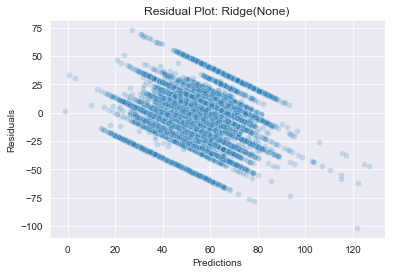

In [94]:
plot_resid(ridge)

# SVM Regressor

In [95]:
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
svr_best = grid_cv(SVR(), param_grid)
svr_best

{'kernel': 'rbf'}

In [96]:
svr = SVR(**svr_best)
score_est(svr)

{'mean_absolute_error': 14.934936775115982,
 'mean_squared_error': 366.62080811646115,
 'r2_score': 0.2829797876614726}

In [97]:
plot_resid(svr)

KeyboardInterrupt: 

# Random Forest

In [67]:
param_grid = {'criterion': ['mse', 'mae']}
randforest_best = grid_cv(RandomForestRegressor(), param_grid)
randforest_best

KeyboardInterrupt: 

In [ ]:
rand_forest = RandomForestClassifier(**randforest_best)
score_est(rand_forest)

In [ ]:
plot_resid(rand_forest)

In [83]:
from importlib import reload
reload(model_util);

# JobLib Serialize Models